In [ ]:
# Install for GPU acceleration
!pip install setuptools pip wheel --upgrade
!pip install nvidia-pyindex
!pip install nvidia-cuda-runtime-cu12

# Install TensorFlow
!pip install tflite-model-maker
!pip install librosa --upgrade
!pip install tensorflow-datasets==4.8.3

In [82]:
import os
import glob
import random

import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.9.3
Model Maker Version: 0.3.4


In [83]:
dataset_dir = './dataset'
test_dir = './dataset-test'

In [84]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path) 
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: 압축기
File: d:\Dev2023\audio-model-maker\dataset-test\압축기\10.공장_23240_1_mono_16bit.wav
Sample rate: 44100
Sample length: 1385666


c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 50517 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52629 missing from current font.
  font.set_text(s, 

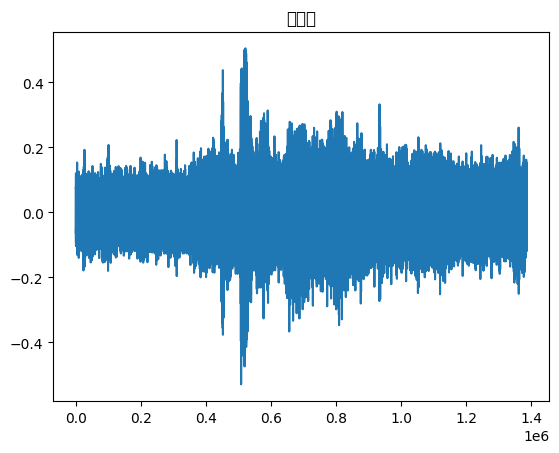

In [85]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [87]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=False,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(False)

train_data_ratio = 0.8
train_data = audio_classifier.DataLoader.from_folder(spec, dataset_dir, cache=True)
train_data, validation_data = train_data.split(train_data_ratio)
test_data = audio_classifier.DataLoader.from_folder(spec, test_dir, cache=True)

batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

INFO:tensorflow:Checkpoints are stored in C:\Users\kmwh0\AppData\Local\Temp\tmp_qyyytxg


INFO:tensorflow:Checkpoints are stored in C:\Users\kmwh0\AppData\Local\Temp\tmp_qyyytxg


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 24)               24600     
                                                                 
Total params: 24,600
Trainable params: 24,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2240/2240 [==============================] - 1125s 502ms/step - loss: 0.9731 - acc: 0.7397 - val_loss: 0.6000 - val_acc: 0.8102
Epoch 2/25
2240/2240 [==============================] - 10s 4ms/step - loss: 0.6193 - acc: 0.8287 - val_loss: 0.4731 - val_acc: 0.8477
Epoch 3/25
2240/2240 [==============================] - 9s 4ms/step - loss: 0.5434 - acc: 0.8473 - val_loss: 0.4271 - val_acc: 0.8608
Epoch 4/25
2240/2240 [==============================] - 9s 4ms/step - loss: 0.5265 - acc: 0.8539 - val_loss: 0.4179 - val_acc: 0.8661
Epoch 5/25
2240/2240 [==============

In [ ]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [88]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'sequential_6')>]


In [91]:
# if you want to try another file just uncoment the line below
random_audio = get_random_audio_file(test_dir)

sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

Test audio path: d:\Dev2023\audio-model-maker\dataset-test\기차\4.열차_67452_1_mono_16bit.wav
Original size of the audio data: 271656
Number of windows for inference: 18
d:\Dev2023\audio-model-maker\dataset-test\기차\4.열차_67452_1_mono_16bit.wav
Result of the window ith:  your model class -> score,  (spec class -> score)
Result of the window 0: 	세탁기 -> 0.786
Result of the window 1: 	세탁기 -> 0.902
Result of the window 2: 	항타기 -> 0.702
Result of the window 3: 	항타기 -> 0.650
Result of the window 4: 	세탁기 -> 0.353
Result of the window 5: 	기차 -> 0.844
Result of the window 6: 	기차 -> 0.838
Result of the window 7: 	공구 -> 0.269
Result of the window 8: 	공구 -> 0.688
Result of the window 9: 	기차 -> 0.601
Result of the window 10: 	기차 -> 0.677
Result of the window 11: 	지하철 -> 0.498
Result of the window 12: 	기차 -> 0.594
Result of the window 13: 	콘크리트펌프 -> 0.764
Result of the window 14: 	세탁기 -> 0.559
Result of the window 15: 	항타기 -> 0.438
Result of the window 16: 	세탁기 -> 0.852
Result of the window 17: 	항타기 -> 0.

In [93]:
models_path = './models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='noises_model.tflite')

Exporing the TFLite model to ./models
INFO:tensorflow:Assets written to: C:\Users\kmwh0\AppData\Local\Temp\tmpf4xj4o0b\assets


INFO:tensorflow:Assets written to: C:\Users\kmwh0\AppData\Local\Temp\tmpf4xj4o0b\assets


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\noises_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models\noises_model.tflite
